In [1]:
import numpy as np
import matplotlib.pyplot as plt
from network_analysis import network_tools as nt
# make figures crisp
%config InlineBackend.figure_format = 'retina'

# General parameters
We first set general parameters of our network.

Namely, we define the characteristic impedance $Z_0$ and the speed of light in the transmission lines $\nu_p$ (a.k.a. phase velocity).

In [2]:
# Parameters
c = 3e8                     # speed of light in vaccum
eps_r = 11.45               # relative permeability of our substrate
vp = c/np.sqrt((1+eps_r)/2) # speed of light in the transmission line
Z0 = 50                     # characteristic impedance

# Example: resonator feedline

We will setup a resonator feedline with three resonators. Each resonator is parametrized by a length $\ell$ which, for a $\lambda/4$ resonator, has resonance frequency:

$f_\mathrm{res} = \frac{\nu_p}{4\ell}$

where $\nu_p$ is the phase velocity in the transmission line.

Additionally, it is also capacitively with a capacitance `C_res` to a matched 50 $\Omega$ feedline.

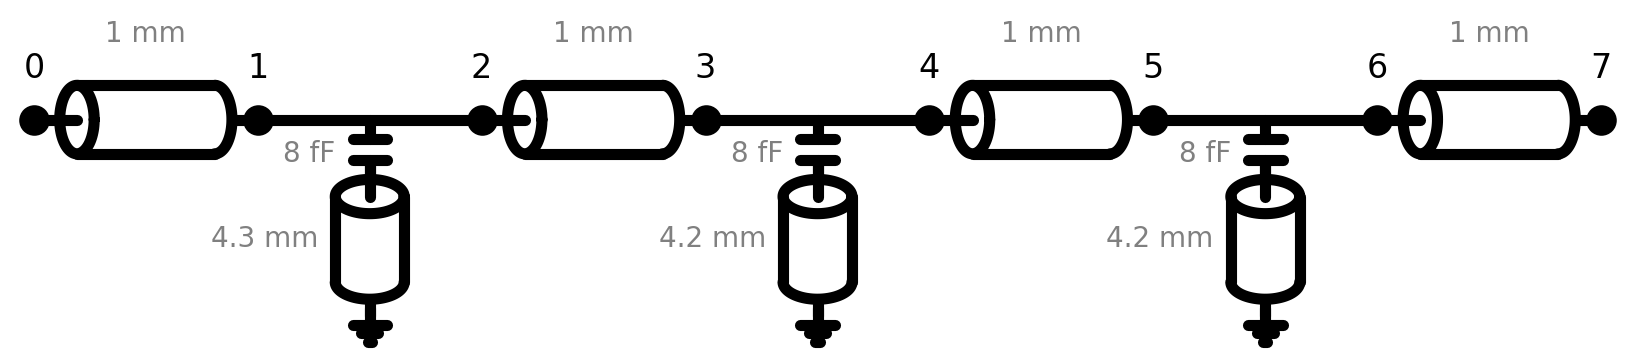

In [3]:
# Setup network
network = nt.Network(Zgen=Z0)

# compute length required for lambda/4 resonator
Resonator_frequencies = [ 7e9,  7.1e9, 7.2e9 ]
Resonator_lengths = [ vp/4/freq for freq in Resonator_frequencies ]
# coupling capacitance of each resonator
C_res = 8e-15

# Add elements to network
for length in Resonator_lengths:
    # add physical separation between resonators
    network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
    # add resonator
    network.add_capacitively_coupled_hanger(length=length, Z0=Z0, phase_velocity=vp, Z_termination=0, C_coupling=C_res)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

We can probe the resonance in accross the feedline using the `get_S_parameters` method.

We find 3 dips corresponding to each resonator, however they are shifted from the predicted $\nu_p/4\ell$ value.

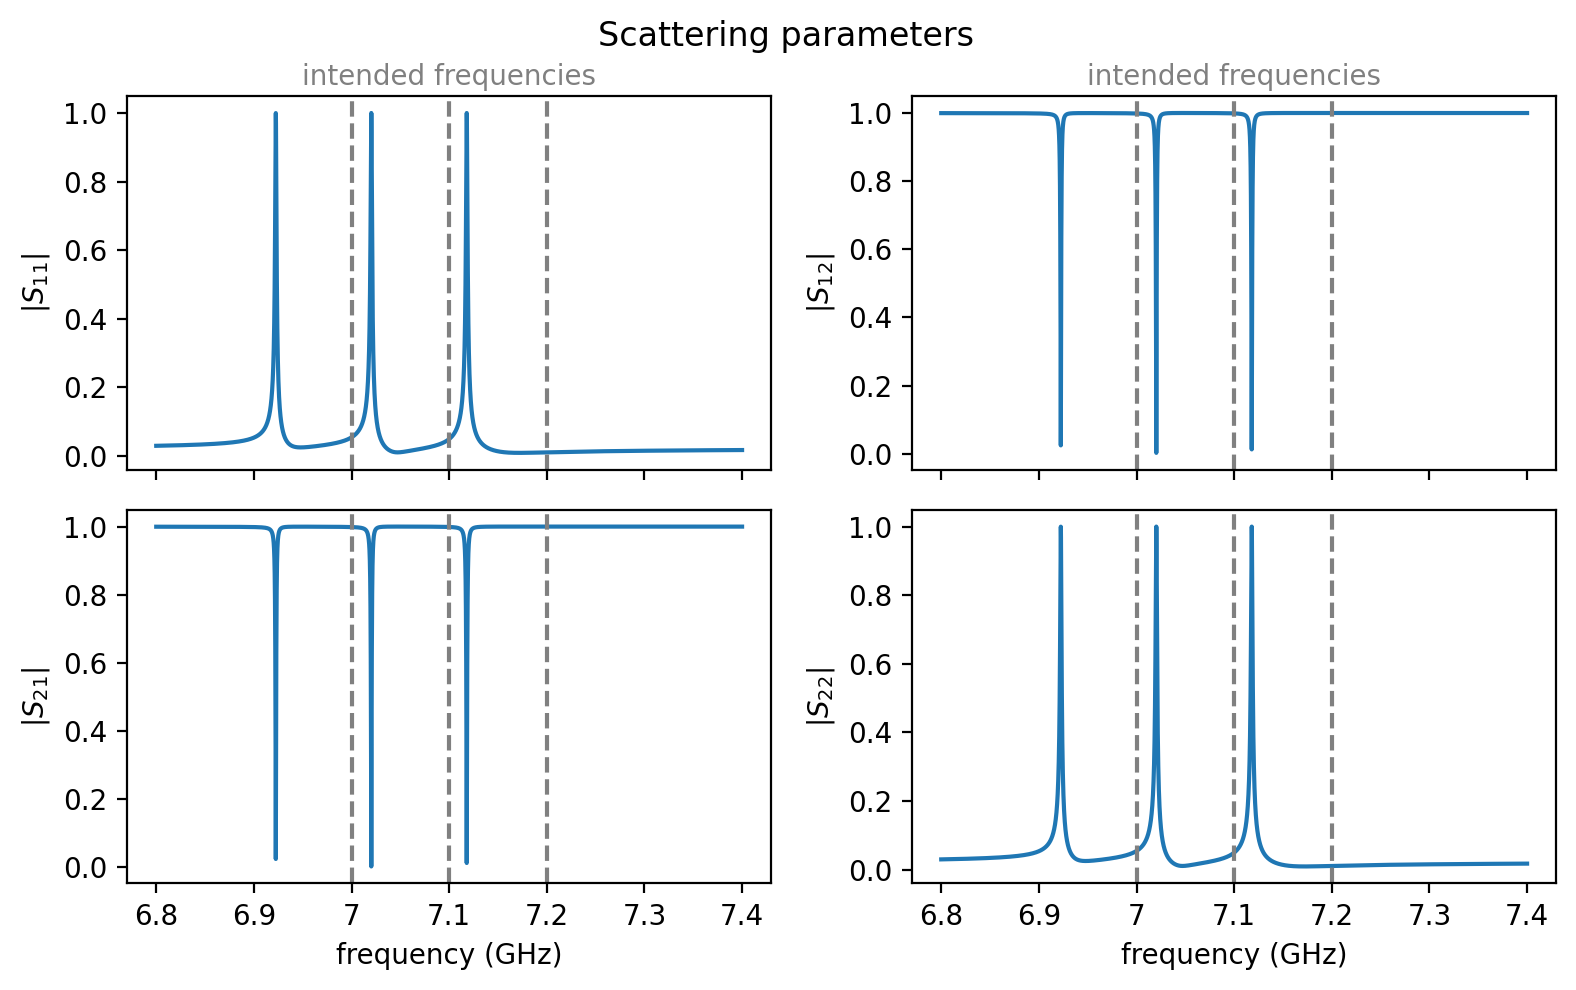

In [4]:
# frequency axis
f_min, f_max = min(Resonator_frequencies), max(Resonator_frequencies)
freq_axis = np.linspace(f_min-200e6, f_max+200e6, 10001)
# scattering parameters
s11, s12, s21, s22 = network.get_S_parameters(frequency=freq_axis, plot=True)
# mark intended resonance frequencies
axs = plt.gcf().get_axes()
for i, ax in enumerate(axs):
    for freq in Resonator_frequencies:
        ax.axvline(freq, color='gray', ls='--')
    if i in [0,1]:
        ax.text(0.5, 1.05, 'intended frequencies', va='center', ha='center', transform=ax.transAxes, color='gray')

This shift arises due to the capacitor loading on the impedance of the resonator. For small values of capacitance, $C$, we can account for it using:

$f_\mathrm{corr} \approx f_\mathrm{res} - 4 Z_0 C f_\mathrm{res}^2$

We can confirm this the validity of this approximation by plotting it:

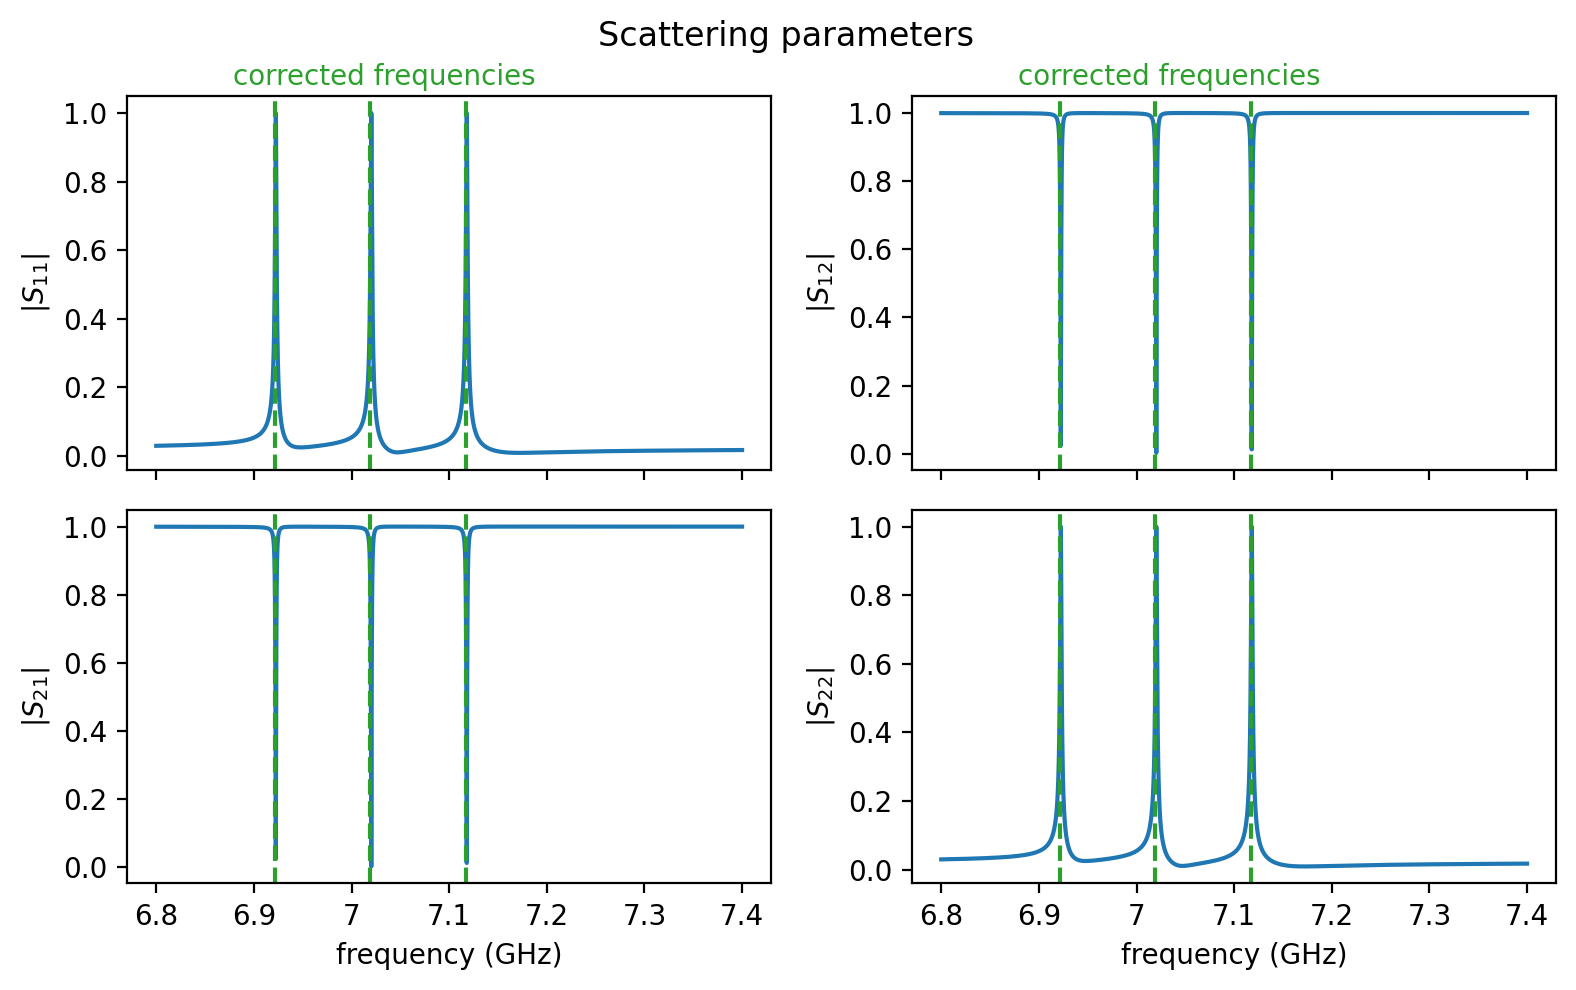

In [5]:
# correction to resonator frequency from capacitor
Resonator_frequencies_corrected = [ freq - 4*Z0*C_res*freq**2 for freq in Resonator_frequencies ]

# scattering parameters
s11, s12, s21, s22 = network.get_S_parameters(frequency=freq_axis, plot=True)
# mark corrected resonance frequencies
axs = plt.gcf().get_axes()
for i, ax in enumerate(axs):
    for freq in Resonator_frequencies_corrected:
        ax.axvline(freq, color='C2', ls='--')
    if i in [0,1]:
        ax.text(0.4, 1.05, 'corrected frequencies', va='center', ha='center', transform=ax.transAxes, color='C2')

In fact, we  can investigate this effect for a single resonator by looking at the scattering parameters as function of the capacitance. To do this we can use the option `element_idx` to instead substitute an existing element in the network. Since we'll sweep the capacitance of the resonator, which is the second element in the network, we use `element_idx=1`.

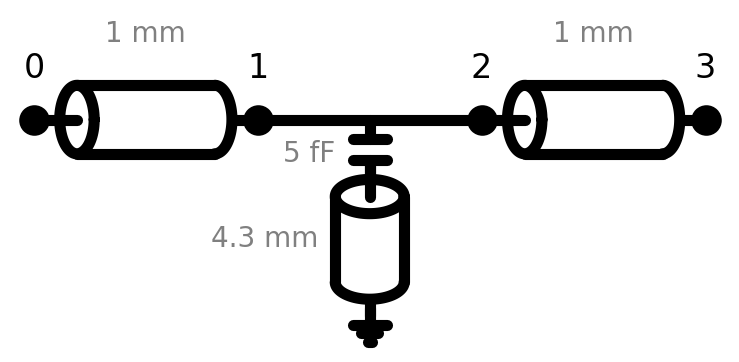

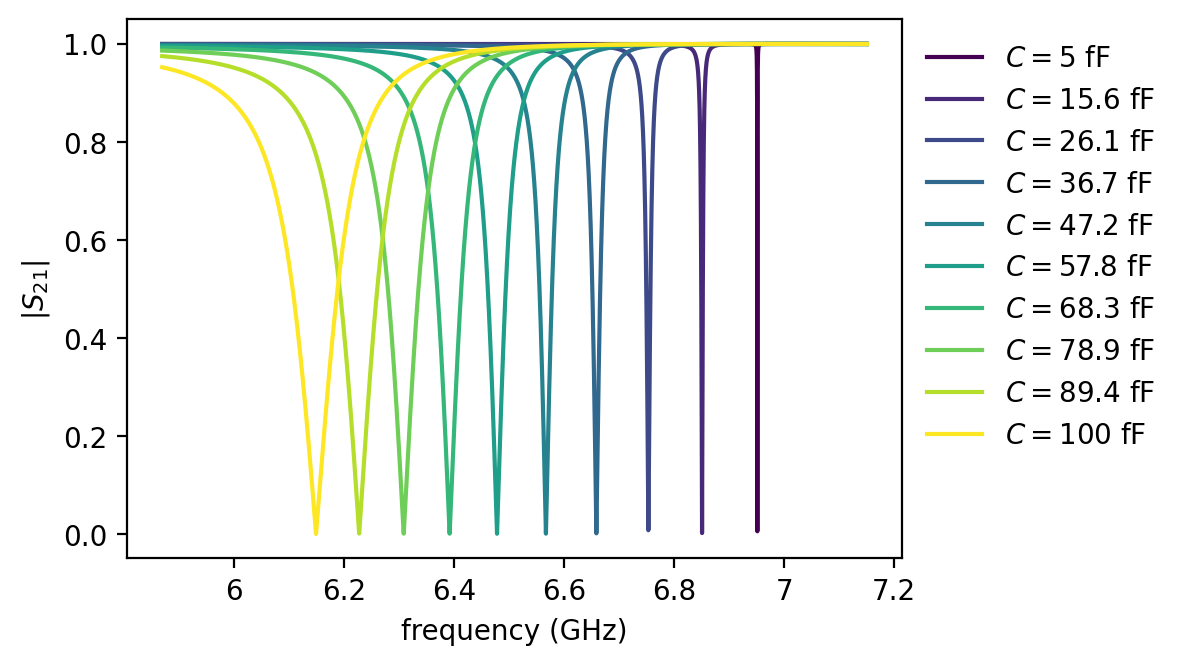

In [6]:
# compute length required for lambda/4 resonator
f_res = 7e9
l_res = vp/4/f_res

# capacitance values to be swept
C_res = np.linspace(5e-15, 100e-15, 10)

# setup single resonator network
network = nt.Network(Zgen=Z0)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.add_capacitively_coupled_hanger(length=l_res, Z0=Z0, phase_velocity=vp, Z_termination=0, C_coupling=C_res[0])
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

# setup frequency sweep axis
f_max, f_min = f_res, f_res - 4*Z0*np.max(C_res)*f_res**2
freq_axis = np.linspace(f_min-150e6, f_max+150e6, 10001)
S21_traces = np.zeros((freq_axis.shape[0], C_res.shape[0]), dtype=complex)

# sweep capacitance in network
for i, c_res in enumerate(C_res):
    # sweep capacitance in resonator
    network.add_capacitively_coupled_hanger(length=l_res, Z0=Z0, phase_velocity=vp, Z_termination=0, C_coupling=c_res, element_idx=1)
    # obtain scattering parameters
    s11, s12, s21, s22 = network.get_S_parameters(frequency=freq_axis)
    S21_traces[:,i] = s21

# plot results
import matplotlib
fig, ax = plt.subplots(figsize=(5,3.5))
cmap = matplotlib.colormaps['viridis']
for i, c_res in enumerate(C_res):
    s21_mag = np.abs(S21_traces)[:,i]
    s21_phase = np.angle(S21_traces)[:,i]
    ax.plot(freq_axis, s21_mag , color=cmap(i/(len(C_res)-1)) , label=f'$C={c_res*1e15:.3g}$ fF')
nt.set_xlabel(ax, 'frequency', unit='Hz')
nt.set_ylabel(ax, '$|S_{21}|$')
ax.legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

# Example: feedline with input capacitor

A common way of improving the efficiency of readout, is to introduce directionality in the feedline using an input capacitor (see J. Heinsoo, et al., PR Applied, 2018). We can simulate such network here! 

Lets start by evaluating the power of the transmitted signal as function of frequency for a given value of input capacitance. According to literature [J. Heinsoo, et al., PR Applied, 2018], a $40$ fF input capacitor should reflect $\sim 2\%$ for typical readout frequencies ($\approx 7$ GHz)

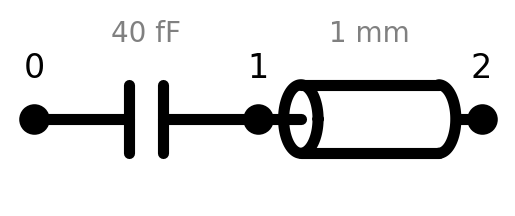

In [7]:
f_readout = 7e9
C_input = 40e-15

# setup feedline with input capacitor
network = nt.Network(Zgen=Z0)
network.add_capacitance(C=C_input, element_type='series')
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

The transmitted power ratio accross the network is given by,

$\frac{P_\mathrm{trans}}{P_\mathrm{in}} = |S_{21}|^2$

analogously, the reflected power ratio,

$\frac{P_\mathrm{refl}}{P_\mathrm{in}} = |S_{11}|^2$

Let's plot this as function of frequency for a 40 fF input capacitor

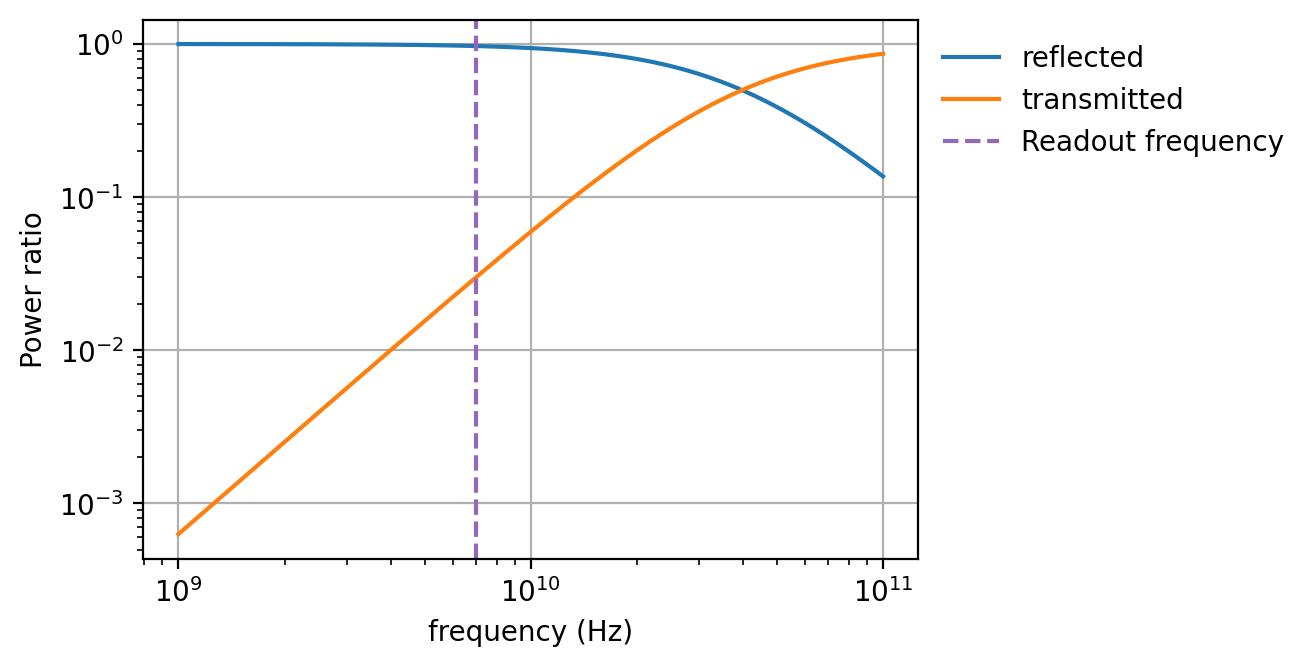

In [8]:
# get scattering parametes
freq_axis = np.linspace(1e9, 100e9, 10001)
s11, s12, s21, s22 = network.get_S_parameters(frequency=freq_axis, plot=False)

# convert to power
P_reflected_ratio = np.abs(s11)**2
P_transmitted_ratio = np.abs(s21)**2

# plot
fig, ax = plt.subplots(figsize=(5,3.5))
ax.plot(freq_axis, P_reflected_ratio, label='reflected')
ax.plot(freq_axis, P_transmitted_ratio, label='transmitted')
ax.axvline(f_readout, color='C4', ls='--', label='Readout frequency')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('Power ratio')
ax.legend(frameon=False, loc=2, bbox_to_anchor=(1,1))
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()

and, as expected, we get about $2\%$ of transmission around 7 GHz. 

As a consequence of this input capacitor, the impedance along the line is no longer $Z_0 = 50\:\Omega$. Instead, the impedance will be a function of both frequency and position along the line. We can assess this by calculating the output impedance of the network $Z_\mathrm{out}$ using the `get_Z_parameters` method.

<Axes: xlabel='position, $x$ (mm)', ylabel='$Z_\\mathrm{out}$ (k$\\Omega$)'>

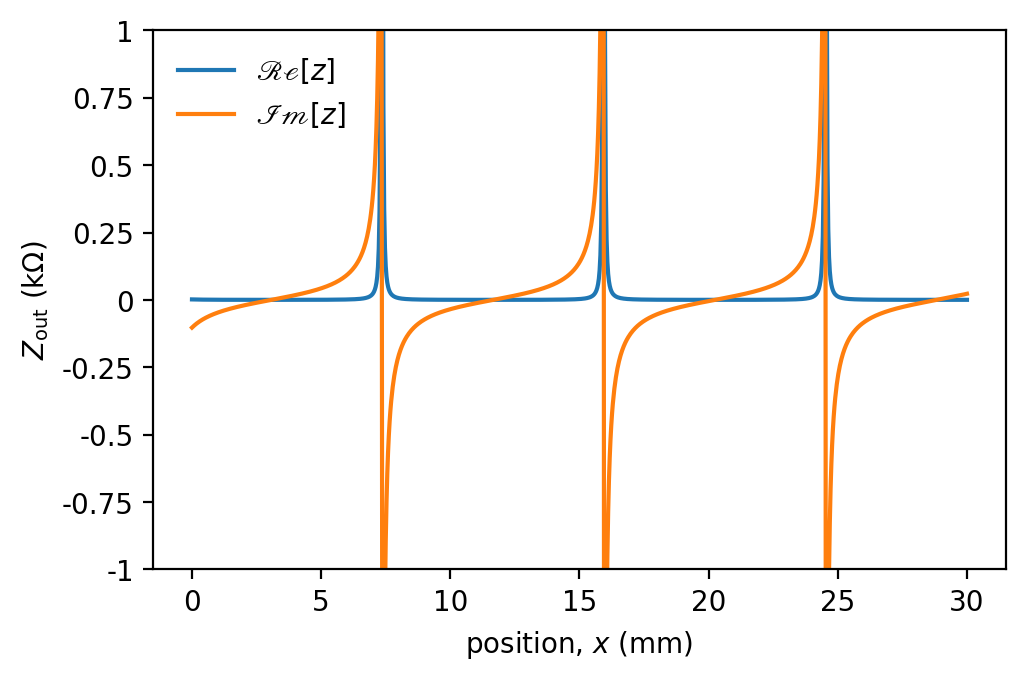

In [12]:
# position along line
Length = np.linspace(0, 30e-3, 1001)
Zout =  np.zeros(Length.shape, dtype=complex)

# sweep position along feedline
for i, length in enumerate(Length):
    network.add_transmission_line(length=length, Z0=Z0, phase_velocity=vp, element_idx=1)
    # obtain impedance parameters
    z11, z12, z21, z22, zin, zout = network.get_Z_parameters(frequency=f_readout, Z_load=Z0)
    Zout[i] = zout[0]

# plot
fig, ax = plt.subplots(figsize=(5.5,3.5))
ax.plot(Length, np.real(Zout), label='$\mathscr{Re}[z]$')
ax.plot(Length, np.imag(Zout), label='$\mathscr{Im}[z]$')
ax.set_ylim(top=1e3, bottom=-1e3)
ax.legend(frameon=False)
nt.set_xlabel(ax, 'position, $x$', unit='m')
nt.set_ylabel(ax, '$Z_\mathrm{out}$', unit='$\Omega$')

The impedance oscillates between $0$ and $\infty$ with periodicity $\ell=\nu_p/2f$. The interpretation of this is that the line now only supports a standing mode with voltage nodes at $Z_\mathrm{out}=0$ and current nodes (aka voltage antinodes) at $Z_\mathrm{out}=\infty$.

This impedance profile will affect how a signal is scattered of the resonator. Particularly given that the resonator couples to this standing mode through its voltage at the coupling capacitor.

In the next cell, we illustrate this effect by plotting $S_{21}$ for different positions of the resonator along the line.

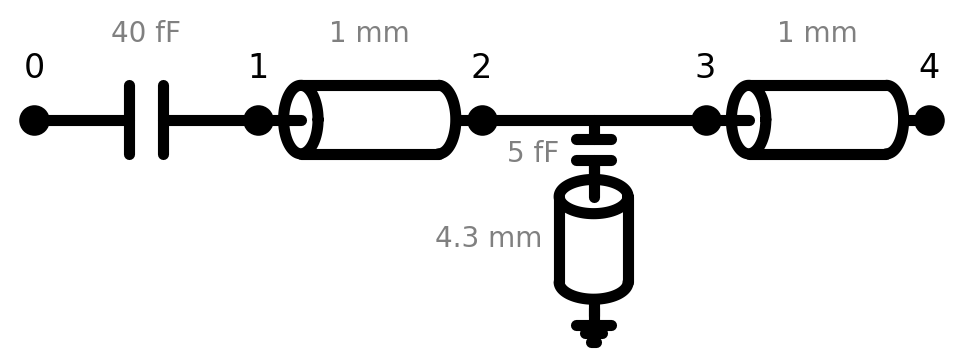

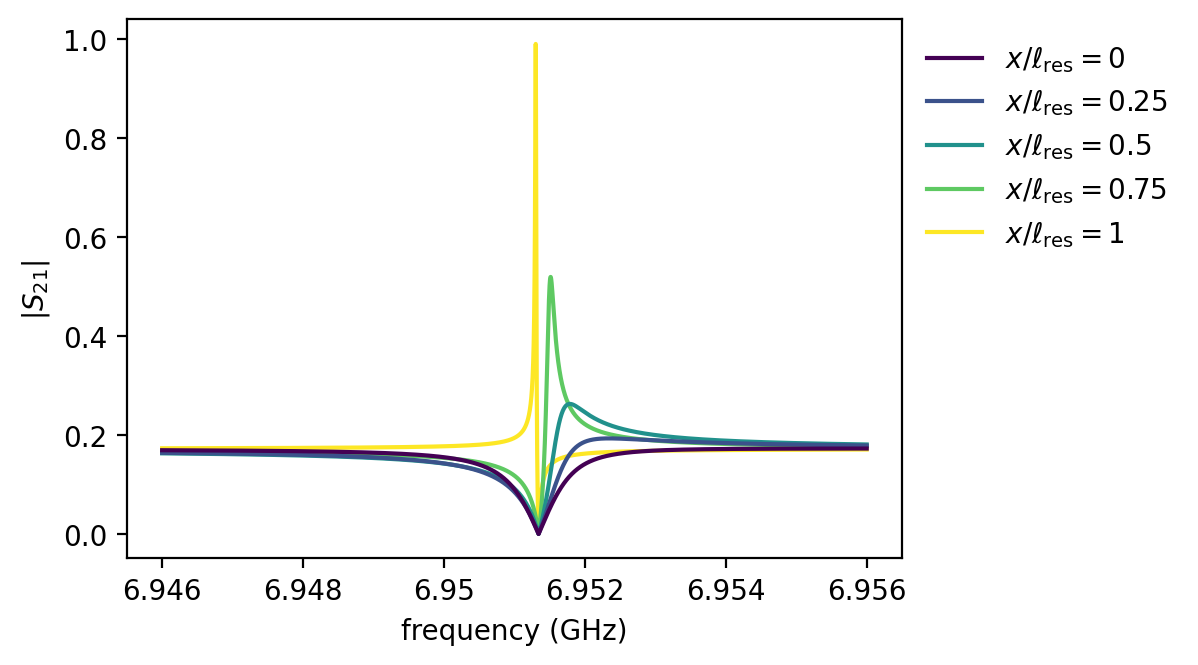

In [10]:
# network parameters
f_res = f_readout
l_res = vp/4/f_res
C_res = 5e-15
# correction to resonance frequency from capacitor
f_corr = f_res - 4*Z0*C_res*f_res**2

# setup feedline with input capacitor and resonator
network = nt.Network(Zgen=Z0)
network.add_capacitance(C=C_input, element_type='series')
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.add_capacitively_coupled_hanger(length=l_res, Z0=Z0, phase_velocity=vp, Z_termination=0, C_coupling=C_res)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

# position along line
Length = np.linspace(0, l_res, 5)
S21_traces = np.zeros((freq_axis.shape[0], Length.shape[0]), dtype=complex)
# frequency axis
freq_axis = f_corr + np.linspace(-5e6, 5e6, 10001)

# sweep position along feedline
for i, length in enumerate(Length):
    network.add_transmission_line(length=length, Z0=Z0, phase_velocity=vp, element_idx=1)
    # calculate scattering parameters
    s11, s12, s21, s22 = network.get_S_parameters(frequency=freq_axis)
    S21_traces[:,i] = s21

# plot results
import matplotlib
fig, ax = plt.subplots(figsize=(5,3.5))
cmap = matplotlib.colormaps['viridis']
for i, length in enumerate(Length):
    s21_mag = np.abs(S21_traces)[:,i]
    s21_phase = np.angle(S21_traces)[:,i]
    ax.plot(freq_axis, s21_mag , color=cmap(i/(len(Length)-1)) , label=f'$x/\ell_\mathrm{{res}}={length/l_res:.2g}$', zorder=-i)
nt.set_xlabel(ax, 'frequency', unit='Hz')
nt.set_ylabel(ax, '$|S_{21}|$')
_ = ax.legend(frameon=False, loc=2, bbox_to_anchor=(1,1))

# Example: readout signal response

Building of the above example, we can plot the signal response of the network to a square readout pulse, resonant with the resonator. 

The scattered output signal can be obtained using the `get_signal_response` method. This method returns 4 output signals,

$s_{11}(t)\:, \:s_{12}(t)\:, \:s_{21}(t)\:, \:s_{2}(t)$

corresponding to scattering from port $i$ to $j$.

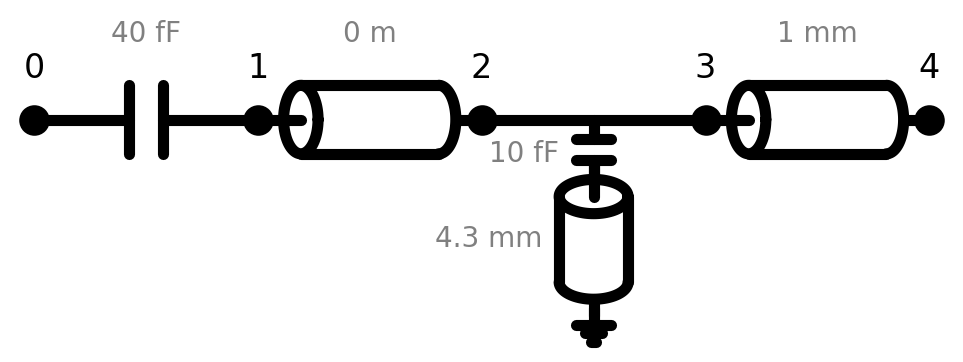

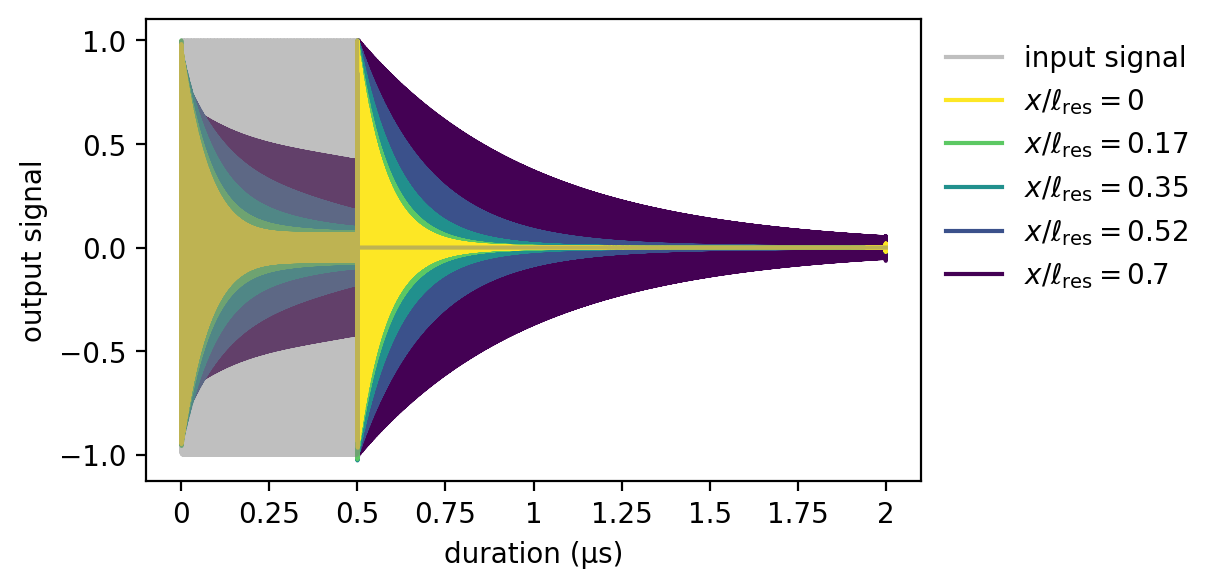

In [13]:
# network parameters
f_res = f_readout
l_res = vp/4/f_res
C_res = 10e-15
# correction to resonance frequency from capacitor
f_corr = f_res - 4*Z0*C_res*f_res**2

# setup feedline with input capacitor and resonator
network = nt.Network(Zgen=Z0)
network.add_capacitance(C=C_input, element_type='series')
network.add_transmission_line(length=0, Z0=Z0, phase_velocity=vp)
network.add_capacitively_coupled_hanger(length=l_res, Z0=Z0, phase_velocity=vp, Z_termination=0, C_coupling=C_res)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

# position along line
Length = np.linspace(0, l_res*.7, 5)
# input signal
time = np.arange(0, 2e-6, .05e-9)
input_signal = nt.square_pulse(time, pulse_duration=.5e-6, frequency=f_corr+1.5e6) # small correction to formula
Output_signal = np.zeros((input_signal.shape[0], Length.shape[0]))

# sweep position along feedline
for i, length in enumerate(Length):
    network.add_transmission_line(length=length, Z0=Z0, phase_velocity=vp, element_idx=1)
    # calculate scattered signal
    time_, signal_11, signal_12, signal_21, signal_22 = network.get_signal_response(time, input_signal)
    Output_signal[:,i] = np.real(signal_21)

# plot results
fig, ax = plt.subplots(figsize=(5,3))
# plot input signal
ax.plot(time, input_signal, color='gray', alpha=.5, label=f'input signal')
# plot output signals
import matplotlib
cmap = matplotlib.colormaps['viridis_r']
for i, length in enumerate(Length):
    out_signal = Output_signal[:,i]/max(Output_signal[:,i])
    ax.plot(time, out_signal , color=cmap(i/(len(Length)-1)), label=f'$x/\ell_\mathrm{{res}}={length/l_res:.2g}$', zorder=-i)
nt.set_xlabel(ax, 'duration', unit='s')
nt.set_ylabel(ax, 'output signal')
ax.legend(frameon=False, loc=2, bbox_to_anchor=(1,1))